In [1]:
using Revise
using ShipMMG
using CSV, DataFrames
using PyPlot, LaTeXStrings, PyCall
using Dierckx, Distributions

@pyimport numpy as np
@pyimport scienceplots

In [2]:
# 模型船スケール(シミュレーションデータ用)
function get_suzaku_model_basic_params(ρ = 1025.0)
    
    L_pp = 3.50  # 船長Lpp[m]
    B = 0.57  # 船幅[m]
    d = 0.16  # 喫水[m]
    nabla = 0.7407 * L_pp * B * d # 排水量[m3] 
    x_G = 0.0112 # 重心位置[]
    D_p = 0.03373 * L_pp # プロペラ直径[m]
    m = nabla * ρ # 質量[kg]
    I_zG = m * ((0.25 * L_pp)^2)  # 慣性モーメント[kg m^2] 
    A_R = 0.0189  # 船の断面に対する舵面積比[-]
    η = 0.8023  # プロペラ直径に対する舵高さ(Dp/H)
    m_x = 0.0475 * m #(0.5 * ρ * (L_pp^2) * d)  # 付加質量x[kg]
    m_y = 0.6739 * m #(0.5 * ρ * (L_pp^2) * d)  # 付加質量y[kg]
    J_z = 0.0306 * m * (L_pp^2) #(0.5 * ρ * (L_pp^4) * d)  # 付加質量Izz[kg]
    f_α = 2.634 # 直圧力勾配係数
    ϵ = 1.345  # プロペラ・舵位置伴流係数比
    t_R = 0.084  # 操縦抵抗減少率 
    a_H = 0.054  # 舵力増加係数
    x_H = -0.388 * L_pp  # 舵力増分作用位置
    γ_R_minus = 0.225 # 整流係数
    γ_R_plus = 0.574  # 整流係数
    l_r_dash = -0.641  # 船長に対する舵位置
    l_R = -0.641  # 船長に対する舵位置
    κ = 0.482  # 修正係数
    t_P = 0.180  # 推力減少率 #モデルの違い
    w_P0 = 0.40  # 有効伴流率 #モデルの違い
    x_P = -0.490  # 船長に対するプロペラ位置 #モデルの違い
    x_R = -0.500 * L_pp

    basic_params = Mmg3DofBasicParams(
        L_pp,
        B,
        d,
        x_G,
        D_p,
        m,
        I_zG,
        A_R,
        η,
        m_x,
        m_y,
        J_z,
        f_α,
        ϵ,
        t_R,
        x_R,
        a_H,
        x_H,
        γ_R_minus,
        γ_R_plus,
        l_R,
        κ,
        t_P,
        w_P0,
        x_P,
    )
    basic_params
end

# 模型船の微係数(シミュレーションデータ用)
function get_suzaku_model_maneuvering_params()
    k_0 = 0.3516
    k_1 = -0.3624
    k_2 = -0.1100
    R_0_dash = 0.020
    X_vv_dash = -0.0799
    X_vr_dash = 0.1016
    X_rr_dash = -0.0176
    X_vvvv_dash = 0.5704
    Y_v_dash = -0.3711
    Y_r_dash = 0.0720
    Y_vvv_dash = -1.0535
    Y_vvr_dash = 0.207
    Y_vrr_dash = -0.2556
    Y_rrr_dash = 0.0220
    N_v_dash = -0.1097
    N_r_dash = -0.0527
    N_vvv_dash = -0.0533
    N_vvr_dash = -0.2863
    N_vrr_dash = -0.0206
    N_rrr_dash = -0.0196

    maneuvering_params = Mmg3DofManeuveringParams(
        k_0,
        k_1,
        k_2,
        R_0_dash,
        X_vv_dash,
        X_vr_dash,
        X_rr_dash,
        X_vvvv_dash,
        Y_v_dash,
        Y_r_dash,
        Y_vvv_dash,
        Y_vvr_dash,
        Y_vrr_dash,
        Y_rrr_dash,
        N_v_dash,
        N_r_dash,
        N_vvv_dash,
        N_vvr_dash,
        N_vrr_dash,
        N_rrr_dash,
    )
    maneuvering_params
end

basic_params = get_suzaku_model_basic_params()
maneuvering_params = get_suzaku_model_maneuvering_params()

L_pp = basic_params.L_pp
B = basic_params.B
d = basic_params.d

function get_suzaku_wind_force_and_moment_params()
    df = CSV.read("./observation/suzaku_windcoef.csv", DataFrame)
    df = df[completecases(df), :]
    ψ_A_vec = deg2rad.(df[!,"psi_A[deg]"])
    C_X_vec = df[!,"CX"]
    C_Y_vec = df[!,"CY"]
    C_N_vec = df[!,"CN"]

    spl_C_X = Spline1D(ψ_A_vec, C_X_vec)
    spl_C_Y = Spline1D(ψ_A_vec, C_Y_vec)
    spl_C_N = Spline1D(ψ_A_vec, C_N_vec)

    A_F = 0.183313 * L_pp * B 
    A_L = 3.143061 * L_pp * d
    
    wind_force_and_moment_params = Mmg3DofWindForceMomentParams(
        A_F,
        A_L,
        spl_C_X,
        spl_C_Y,
        spl_C_N, 
    )
    wind_force_and_moment_params
end

wind_force_and_moment_params = get_suzaku_wind_force_and_moment_params()

Mmg3DofWindForceMomentParams{Float64}
  A_F: Float64 0.36570943499999997
  A_L: Float64 1.76011416
  spl_C_X: Spline1D
  spl_C_Y: Spline1D
  spl_C_N: Spline1D


In [3]:
# 舵角・プロペラ回転数設定
max_δ_rad = 20.0 * pi / 180.0  # [rad]
n_const = 21.21824  # [rps]

# シミュレーション期間の設定
duration = 200  # [s]
sampling = duration * 4
time_list = range(0.00, stop=duration,  step=1/4)
δ_rad_list = max_δ_rad .* ones(Float64, length(time_list))
n_p_list = n_const .* ones(Float64, length(time_list))

# 外力の設定
μ_U_W = 8.0 # [m/s]
μ_ψ_W = 0.0 # [rad]  
σ_U_W = 0.0 # [m/s]
σ_ψ_W = 0.0 # [rad]
U_W_list = rand(Normal(μ_U_W, σ_U_W), length(time_list))
ψ_W_list = rand(Normal(μ_ψ_W, σ_ψ_W), length(time_list))

#シミュレーションの実行(平水中)
mmg_results = mmg_3dof_simulate(basic_params,maneuvering_params,time_list,δ_rad_list,n_p_list,u0=1.441442,v0=0.0,r0=0.0,)

#シミュレーションの実行(風あり)
#mmg_results = mmg_3dof_simulate(basic_params,maneuvering_params,wind_force_and_moment_params,time_list,δ_rad_list,n_p_list,U_W_list,ψ_W_list,u0=1.441442,v0=0.0,r0=0.0,)

u, v, r, x, y, ψ, δ, n_p = mmg_results
x_est, y_est, ψ_est = calc_position(time_list, u, v, r)

#シミュレーションデータ保管
df = DataFrame(
    time = time_list,
    u = u,
    v = v,
    r = r,
    δ = δ,
    n_p = n_p,
    x_est = x_est,
    y_est = y_est,
    ψ_est = ψ_est,
    U_W = U_W_list,
    ψ_W = ψ_W_list,
)

L_f = 1.0
L_t = 1.0

x1 =df[!,"x_est"] .+ L_f .*cos.(df[!,"ψ_est"])
y1 =df[!,"y_est"] .+ L_f .*sin.(df[!,"ψ_est"])
x2 =df[!,"x_est"] .+ L_f .*cos.(df[!,"ψ_est"] .+ pi)
y2 =df[!,"y_est"] .+ L_f .*sin.(df[!,"ψ_est"] .+ pi)

df[!, "x1"] = x1
df[!, "y1"] = y1
df[!, "x2"] = x2
df[!, "y2"] = y2

#シミュレーションデータ書き出し
CSV.write("./observation/suzaku_sim_data.csv", df)

"./observation/suzaku_sim_data.csv"

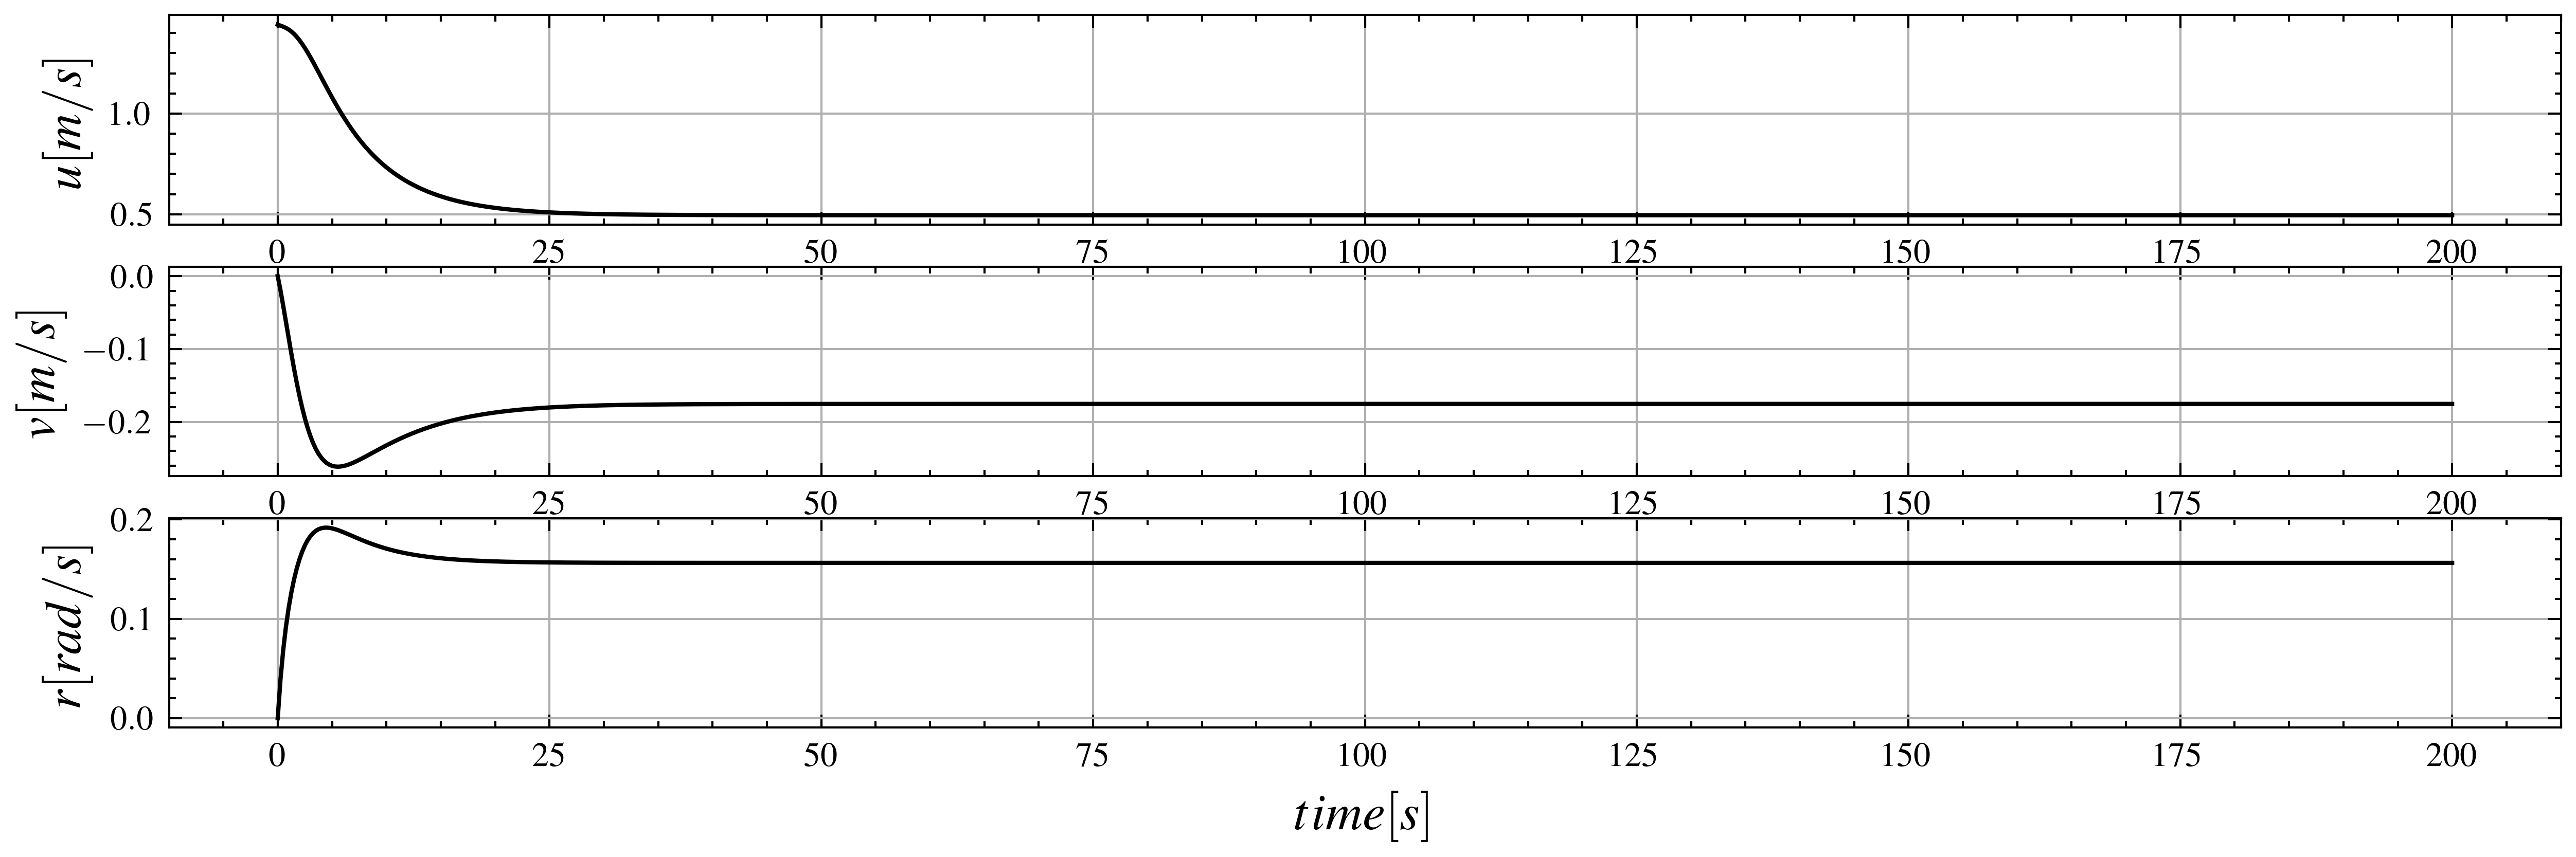

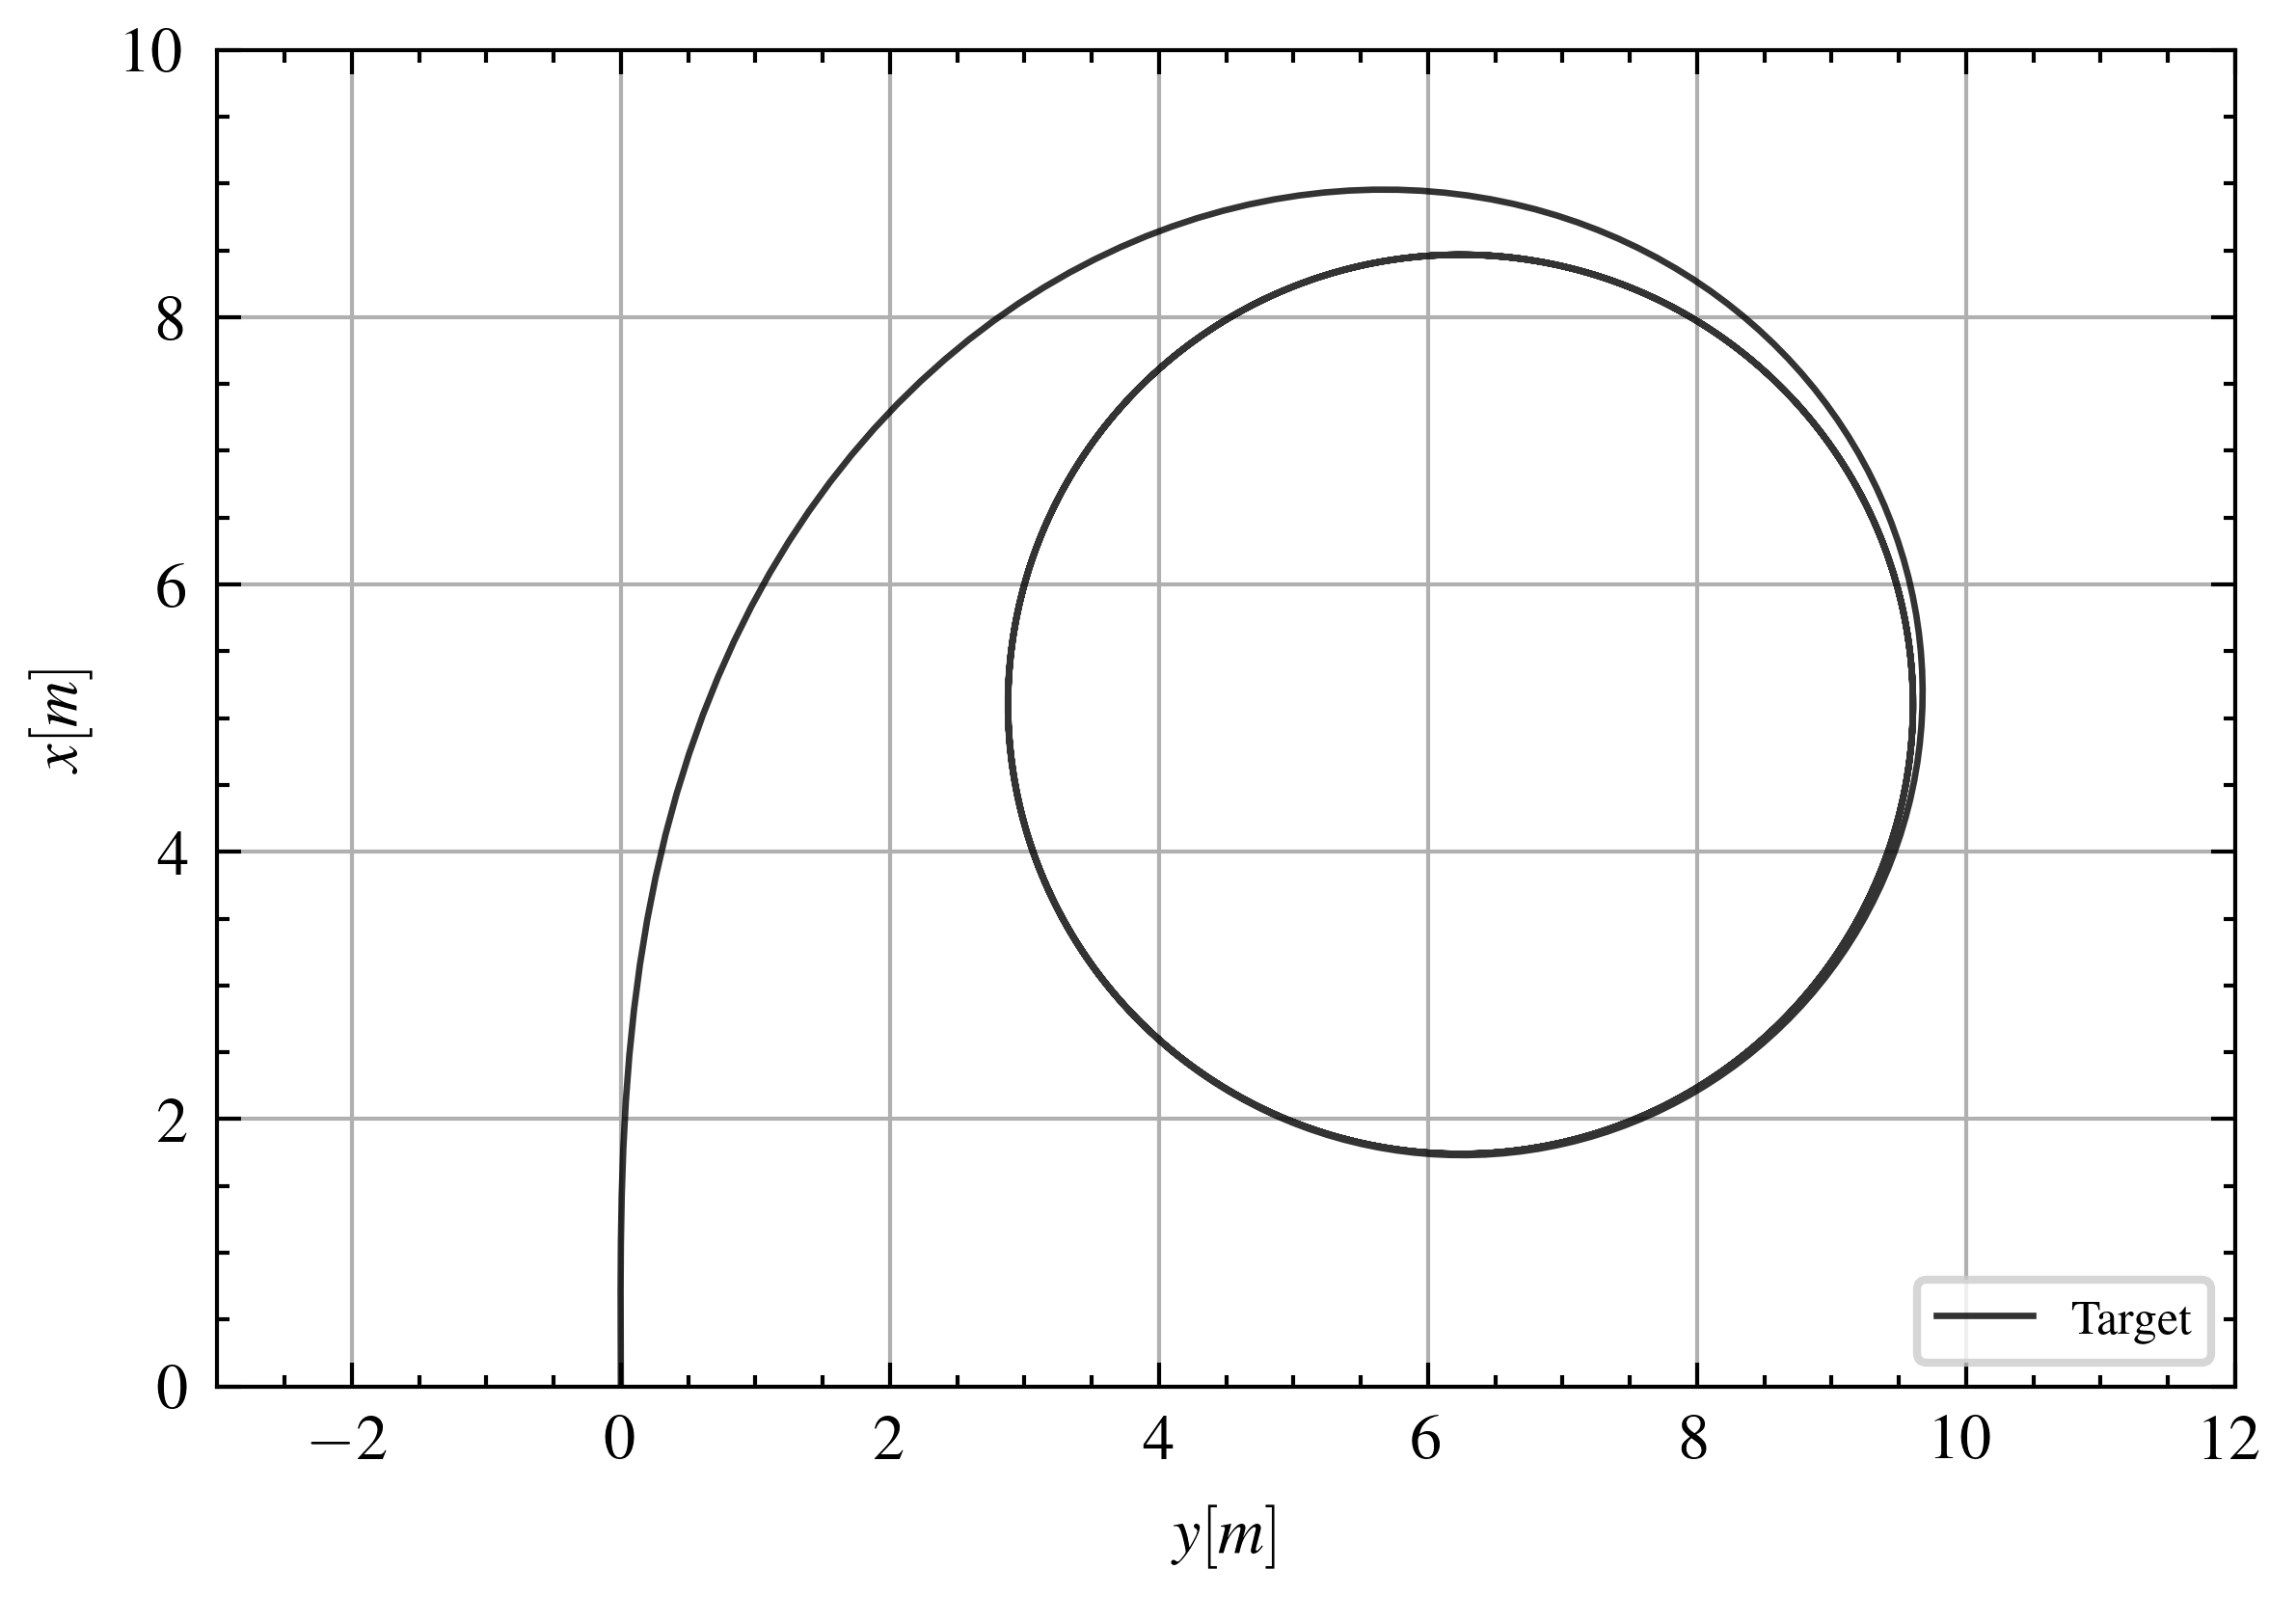

In [4]:
# グラフスタイルの設定
plt.style.use(["science", "ieee"])

# データの読み込み
obs = CSV.read("./observation/suzaku_sim_data.csv", DataFrame)

fig = plt.figure(figsize=(10,3))

ax = fig.add_subplot(3, 1, 1)
ax.plot(obs[!,"time"], obs[!,"u"], "-", c="k", linewidth=1)
ax.set_ylabel(L"u[m/s]", fontsize=12)
ax.grid()
ax = fig.add_subplot(3, 1, 2)
ax.plot(obs[!,"time"], obs[!,"v"], "-", c="k", linewidth=1)
ax.set_ylabel(L"v[m/s]", fontsize=12)
ax.grid()
ax = fig.add_subplot(3, 1, 3)
ax.plot(obs[!,"time"], obs[!,"r"], "-", c="k", linewidth=1)
ax.set_ylabel(L"r[rad/s]", fontsize=12)
ax.set_xlabel(L"time[s]", fontsize=12)
ax.grid()
fig = plt.figure(figsize=(4.5,3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(obs[!,"y_est"], obs[!,"x_est"], "-", label="Target", c="k", alpha=0.8, linewidth=0.8)
ax.set_ylabel(L"x[m]", fontsize=8)
ax.set_xlabel(L"y[m]", fontsize=8)
ax.legend(frameon=true, loc="lower right", fontsize=6)
ax.set_ylim(0, 10)
ax.set_xlim(-3, 12)
ax.grid()